Downloading files from kaggle.

In [1]:
!pip install kaggle


In [2]:
%%writefile kaggle.json
{
  "username": "<Enter your username>",
  "key": "<Enter your api key>"
}


Writing kaggle.json


In [4]:
!kaggle --version


Kaggle API 1.7.4.5


In [5]:
!kaggle datasets download -d uwrfkaggler/ravdess-emotional-speech-audio


Dataset URL: https://www.kaggle.com/datasets/uwrfkaggler/ravdess-emotional-speech-audio
License(s): CC-BY-NC-SA-4.0
 85% 363M/429M [00:00<00:00, 610MB/s]
100% 429M/429M [00:00<00:00, 536MB/s]


In [6]:
!unzip ravdess-emotional-speech-audio.zip


Archive:  ravdess-emotional-speech-audio.zip
  inflating: Actor_01/03-01-01-01-01-01-01.wav  
  inflating: Actor_01/03-01-01-01-01-02-01.wav  
  inflating: Actor_01/03-01-01-01-02-01-01.wav  
  inflating: Actor_01/03-01-01-01-02-02-01.wav  
  inflating: Actor_01/03-01-02-01-01-01-01.wav  
  inflating: Actor_01/03-01-02-01-01-02-01.wav  
  inflating: Actor_01/03-01-02-01-02-01-01.wav  
  inflating: Actor_01/03-01-02-01-02-02-01.wav  
  inflating: Actor_01/03-01-02-02-01-01-01.wav  
  inflating: Actor_01/03-01-02-02-01-02-01.wav  
  inflating: Actor_01/03-01-02-02-02-01-01.wav  
  inflating: Actor_01/03-01-02-02-02-02-01.wav  
  inflating: Actor_01/03-01-03-01-01-01-01.wav  
  inflating: Actor_01/03-01-03-01-01-02-01.wav  
  inflating: Actor_01/03-01-03-01-02-01-01.wav  
  inflating: Actor_01/03-01-03-01-02-02-01.wav  
  inflating: Actor_01/03-01-03-02-01-01-01.wav  
  inflating: Actor_01/03-01-03-02-01-02-01.wav  
  inflating: Actor_01/03-01-03-02-02-01-01.wav  
  inflating: Actor_01/03

In [8]:
import os

DATASET_PATH = "/content"

actor_folders = sorted([f for f in os.listdir(DATASET_PATH) if f.startswith("Actor_")])
print(actor_folders[:5], "...")
print("Total actors:", len(actor_folders))


['Actor_01', 'Actor_02', 'Actor_03', 'Actor_04', 'Actor_05'] ...
Total actors: 24


In [ ]:
wav_files = []

for actor in actor_folders:
    actor_path = os.path.join(DATASET_PATH, actor)
    for file in os.listdir(actor_path):
        if file.endswith(".wav"):
            wav_files.append(os.path.join(actor_path, file))

print("Total wav files:", len(wav_files))


Performing Audio Trimming

In [69]:
import numpy as np
import librosa
import random
import IPython.display as ipd



In [ ]:
def load_and_trim_audio(file_path, duration=3.0, top_db=25, buffer_ms=50):
    y, sr = librosa.load(file_path, sr=None, duration=duration)

    y_trimmed, idx = librosa.effects.trim(y, top_db=top_db)
    start, end = idx

    buffer = int(buffer_ms * sr / 1000)

    start = max(0, start - buffer)
    end = min(len(y), end + buffer)

    y_trimmed = y[start:end]

    return y, y_trimmed, sr


In [ ]:
#This is just for testing audio trimming. I used to set my TOP_DB.

import IPython.display as ipd

DURATION = 3.0
TOP_DB = 25

for i in range(5):
    print("=" * 60)
    print(f"File {i+1}: {os.path.basename(wav_files[i])}")

    y, y_trimmed, sr = load_and_trim_audio(
        wav_files[i],
        duration=DURATION,
        top_db=TOP_DB
    )

    print(f"Original duration: {len(y)/sr:.2f}s")
    print(f"Trimmed duration:  {len(y_trimmed)/sr:.2f}s")

    print("Original audio:")
    display(ipd.Audio(y, rate=sr))

    print("Trimmed audio:")
    display(ipd.Audio(y_trimmed, rate=sr))


Visual analysis and feature engineering

In [12]:

def compute_log_mel(
    y,
    sr,
    n_mels=128,
    n_fft=2048,
    hop_length=512
):
    mel = librosa.feature.melspectrogram(
        y=y,
        sr=sr,
        n_mels=n_mels,
        n_fft=n_fft,
        hop_length=hop_length
    )
    log_mel = librosa.power_to_db(mel, ref=np.max)
    return log_mel


In [13]:

def get_files_by_emotion(wav_files, emotion_code, n=3, seed=42):
    random.seed(seed)
    matching = [f for f in wav_files if f.split("-")[2] == emotion_code]
    return random.sample(matching, n)


In [14]:
import matplotlib.pyplot as plt
import librosa.display

def plot_log_mel(log_mel, sr, title):
    plt.imshow(log_mel, origin="lower", aspect="auto", cmap="magma")
    plt.colorbar(label="dB")
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Mel Frequency")


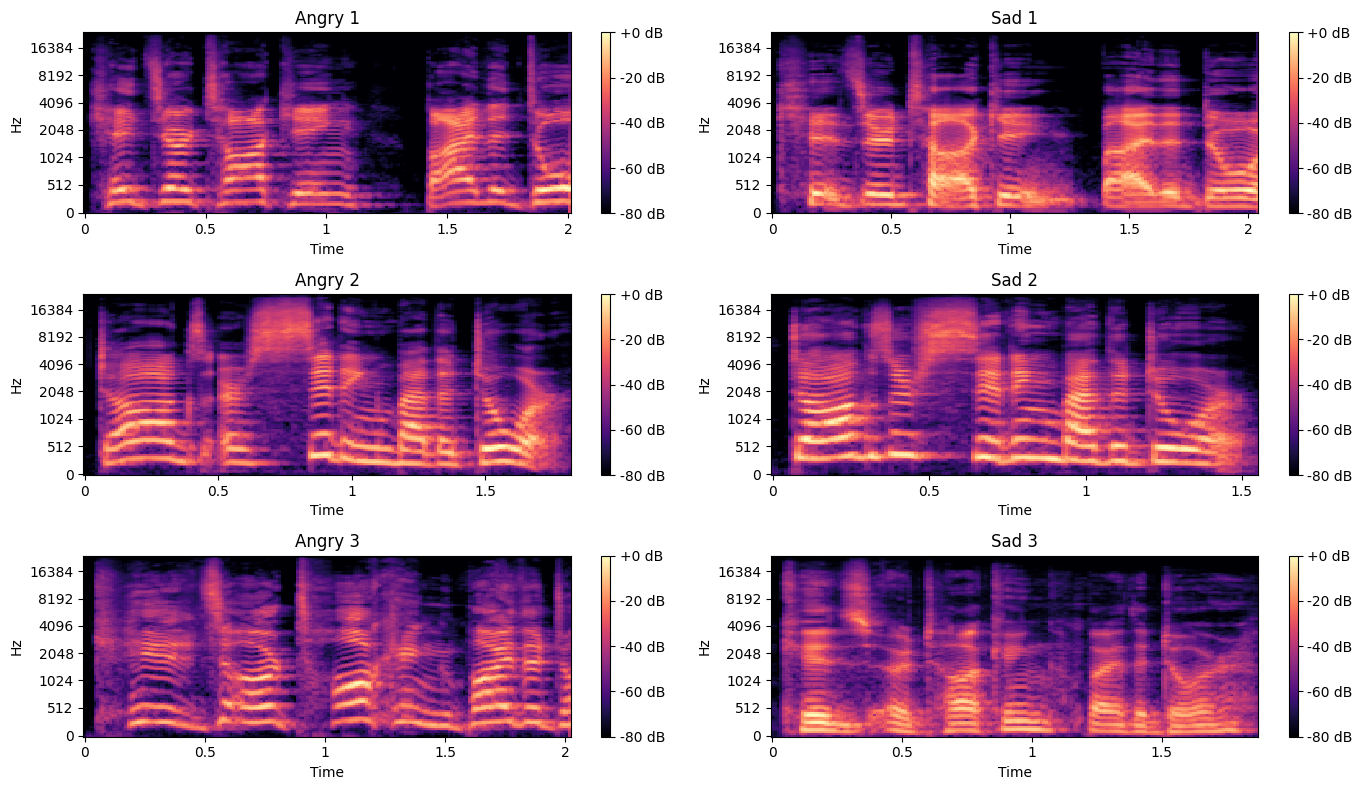

In [15]:

angry_files = get_files_by_emotion(wav_files, "05", n=3)
sad_files   = get_files_by_emotion(wav_files, "04", n=3)

plt.figure(figsize=(14, 8))


for i, f in enumerate(angry_files):
    y, y_trimmed, sr = load_and_trim_audio(f)
    mel = compute_log_mel(y_trimmed, sr)

    plt.subplot(3, 2, 2*i + 1)
    librosa.display.specshow(
        mel,
        sr=sr,
        hop_length=512,
        x_axis="time",
        y_axis="mel"
    )
    plt.title(f"Angry {i+1}")
    plt.colorbar(format="%+2.0f dB")

for i, f in enumerate(sad_files):
    y, y_trimmed, sr = load_and_trim_audio(f)
    mel = compute_log_mel(y_trimmed, sr)

    plt.subplot(3, 2, 2*i + 2)
    librosa.display.specshow(
        mel,
        sr=sr,
        hop_length=512,
        x_axis="time",
        y_axis="mel"
    )
    plt.title(f"Sad {i+1}")
    plt.colorbar(format="%+2.0f dB")

plt.tight_layout()
plt.show()


In [17]:
# ===== Feature Engineering Parameters =====

FE_DURATION = 3.0
FE_TOP_DB = 25
FE_BUFFER_MS = 50

FE_N_MELS = 128
FE_N_FFT = 2048
FE_HOP_LENGTH = 512

FE_MAX_FRAMES = 128


In [18]:
import numpy as np
import librosa

def extract_log_mel_feature(file_path):

    y, y_trimmed, sr = load_and_trim_audio(
        file_path,
        duration=FE_DURATION,
        top_db=FE_TOP_DB,
        buffer_ms=FE_BUFFER_MS
    )


    mel = librosa.feature.melspectrogram(
        y=y_trimmed,
        sr=sr,
        n_fft=FE_N_FFT,
        hop_length=FE_HOP_LENGTH,
        n_mels=FE_N_MELS
    )


    log_mel = librosa.power_to_db(mel, ref=np.max)

    num_frames = log_mel.shape[1]

    if num_frames < FE_MAX_FRAMES:
        pad_width = FE_MAX_FRAMES - num_frames
        log_mel = np.pad(log_mel, ((0, 0), (0, pad_width)))
    else:
        log_mel = log_mel[:, :FE_MAX_FRAMES]

    return log_mel


In [19]:
test_spec = extract_log_mel_feature(wav_files[0])

print("Feature shape:", test_spec.shape)
print("Min value (dB):", test_spec.min())
print("Max value (dB):", test_spec.max())


Feature shape: (128, 128)
Min value (dB): -80.0
Max value (dB): 0.0


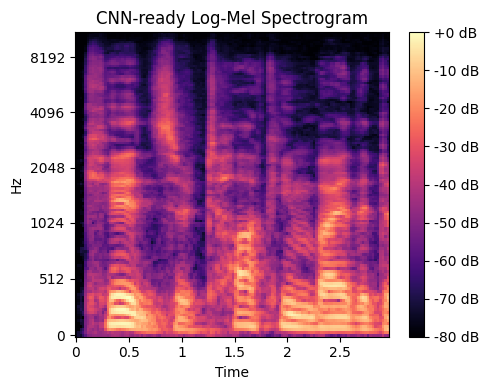

In [20]:
#used to test 1 log-mel spectrogram
import librosa.display
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 4))
librosa.display.specshow(
    test_spec,
    sr=22050,
    hop_length=FE_HOP_LENGTH,
    x_axis="time",
    y_axis="mel"
)
plt.colorbar(format="%+2.0f dB")
plt.title("CNN-ready Log-Mel Spectrogram")
plt.tight_layout()
plt.show()


In [21]:
X = []

for file_path in wav_files:
    features = extract_log_mel_feature(file_path)
    X.append(features)

X = np.array(X)
X = X[..., np.newaxis]


Data Augmentation


In [ ]:
def add_noise(y, noise_factor=0.002):
    noise = np.random.randn(len(y))
    return y + noise_factor * noise


def pitch_shift(y, sr, n_steps=2):
    return librosa.effects.pitch_shift(y, sr=sr, n_steps=n_steps)


def time_stretch(y, rate=0.9):
    return librosa.effects.time_stretch(y, rate=rate)




In [ ]:
def apply_random_augmentation(y, sr):
    choice = random.choice(["none", "noise", "pitch", "stretch"])

    if choice == "noise":
        return add_noise(y)

    elif choice == "pitch":
        return pitch_shift(y, sr, n_steps=random.choice([-1, 1]))

    elif choice == "stretch":
        return time_stretch(y, rate=random.uniform(0.95, 1.05))

    return y


In [ ]:
#testing augmentation
import IPython.display as ipd

y, y_trimmed, sr = load_and_trim_audio(wav_files[0])

y_aug = apply_random_augmentation(y_trimmed, sr)

print("Original:")
display(ipd.Audio(y_trimmed, rate=sr))

print("Augmented:")
display(ipd.Audio(y_aug, rate=sr))


In [ ]:
def extract_features_with_augmentation(file_path):
    """
    Feature extraction pipeline WITH augmentation.
    Used only for training data.
    """

    # Load and trim
    y, y_trimmed, sr = load_and_trim_audio(
        file_path,
        duration=FE_DURATION,
        top_db=FE_TOP_DB,
        buffer_ms=FE_BUFFER_MS
    )

    # Apply random augmentation
    y_aug = apply_random_augmentation(y_trimmed, sr)

    # Convert to Log-Mel
    mel = librosa.feature.melspectrogram(
        y=y_aug,
        sr=sr,
        n_fft=FE_N_FFT,
        hop_length=FE_HOP_LENGTH,
        n_mels=FE_N_MELS
    )

    log_mel = librosa.power_to_db(mel, ref=np.max)

    # Pad / crop
    if log_mel.shape[1] < FE_MAX_FRAMES:
        pad = FE_MAX_FRAMES - log_mel.shape[1]
        log_mel = np.pad(log_mel, ((0, 0), (0, pad)))
    else:
        log_mel = log_mel[:, :FE_MAX_FRAMES]

    return log_mel


Dataset Split: Stratified Train / Validation / Test


In [27]:
from sklearn.preprocessing import LabelEncoder
import numpy as np


In [28]:
emotion_map = {
    "01": "neutral",
    "02": "calm",
    "03": "happy",
    "04": "sad",
    "05": "angry",
    "06": "fearful",
    "07": "disgust",
    "08": "surprised"
}

label_names = [emotion_map[f.split("-")[2]] for f in wav_files]

print("First 10 labels:", label_names[:10])
print("Total labels:", len(label_names))


First 10 labels: ['calm', 'angry', 'fearful', 'disgust', 'surprised', 'fearful', 'angry', 'calm', 'sad', 'calm']
Total labels: 1440


In [29]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(label_names)

print("Encoded classes:", list(label_encoder.classes_))
print("Sample encoded labels:", y_encoded[:10])


Encoded classes: [np.str_('angry'), np.str_('calm'), np.str_('disgust'), np.str_('fearful'), np.str_('happy'), np.str_('neutral'), np.str_('sad'), np.str_('surprised')]
Sample encoded labels: [1 0 3 2 7 3 0 1 6 1]


In [30]:
from sklearn.model_selection import train_test_split


In [31]:
X_paths = np.array(wav_files)
y_labels = np.array(y_encoded)

X_train_paths, X_temp_paths, y_train, y_temp = train_test_split(
    X_paths,
    y_labels,
    test_size=0.20,
    stratify=y_labels,
    random_state=42
)

print("Train size:", len(X_train_paths))
print("Temp size:", len(X_temp_paths))


Train size: 1152
Temp size: 288


In [32]:
X_val_paths, X_test_paths, y_val, y_test = train_test_split(
    X_temp_paths,
    y_temp,
    test_size=0.50,
    stratify=y_temp,
    random_state=42
)

print("Validation size:", len(X_val_paths))
print("Test size:", len(X_test_paths))


Validation size: 144
Test size: 144


In [33]:
from collections import Counter

def show_distribution(labels, name):
    print(f"\n{name} distribution:")
    dist = Counter(labels)
    for cls, count in sorted(dist.items()):
        print(f"Class {cls}: {count}")

show_distribution(y_train, "Train")
show_distribution(y_val, "Validation")
show_distribution(y_test, "Test")



Train distribution:
Class 0: 154
Class 1: 154
Class 2: 154
Class 3: 153
Class 4: 153
Class 5: 77
Class 6: 154
Class 7: 153

Validation distribution:
Class 0: 19
Class 1: 19
Class 2: 19
Class 3: 19
Class 4: 20
Class 5: 9
Class 6: 19
Class 7: 20

Test distribution:
Class 0: 19
Class 1: 19
Class 2: 19
Class 3: 20
Class 4: 19
Class 5: 10
Class 6: 19
Class 7: 19


In [34]:
import numpy as np


In [35]:
X_train = np.array([
    extract_features_with_augmentation(fp) for fp in X_train_paths
])[..., np.newaxis]


In [36]:
X_val = np.array([
    extract_log_mel_feature(fp) for fp in X_val_paths
])[..., np.newaxis]


In [37]:
X_test = np.array([
    extract_log_mel_feature(fp) for fp in X_test_paths
])[..., np.newaxis]


In [38]:
print(X_train.shape, X_val.shape, X_test.shape)


(1152, 128, 128, 1) (144, 128, 128, 1) (144, 128, 128, 1)


In [39]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Input, Conv2D, BatchNormalization,
    MaxPooling2D, Dropout,
    GlobalAveragePooling2D, Dense
)


In [40]:
model = Sequential([


    Input(shape=(128, 128, 1)),


    Conv2D(32, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.3),


    Conv2D(64, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.3),


    Conv2D(128, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.3),


    GlobalAveragePooling2D(),


    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(8, activation='softmax')
])


In [41]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


In [42]:
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 111,112 (434.03 KB)

 Trainable params: 110,664 (432.28 KB)

 Non-trainable params: 448 (1.75 KB)

In [43]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)


In [44]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=32,
    callbacks=[early_stop]
)



Epoch 1/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 63s 2s/step - accuracy: 0.1589 - loss: 2.1505 - val_accuracy: 0.1389 - val_loss: 3.4941
Epoch 2/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.2327 - loss: 1.9463 - val_accuracy: 0.1319 - val_loss: 2.3535
Epoch 3/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step - accuracy: 0.2675 - loss: 1.8657 - val_accuracy: 0.2431 - val_loss: 2.0040
Epoch 4/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 90s 2s/step - accuracy: 0.3313 - loss: 1.7644 - val_accuracy: 0.2083 - val_loss: 1.9866
Epoch 5/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - accuracy: 0.3228 - loss: 1.7289 - val_accuracy: 0.1389 - val_loss: 3.1473
Epoch 6/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step - accuracy: 0.3390 - loss: 1.7002 - val_accuracy: 0.2500 - val_loss: 1.8546
Epoch 7/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step - accuracy: 0.3541 - loss: 1.6320 - val_accuracy: 0.2153 - val_loss: 2.1044
Epoch 8/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step - accuracy: 0.4075 - loss: 1.5921 - val_accuracy: 0.1389 - val_loss:

In [45]:
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 274ms/step


Evaluation and confusion matrix

In [46]:
from sklearn.metrics import f1_score, confusion_matrix, classification_report


In [47]:
macro_f1 = f1_score(y_test, y_pred_labels, average='macro')
print("Macro F1-score:", macro_f1)


Macro F1-score: 0.35305887392101576


In [48]:
import seaborn as sns
import matplotlib.pyplot as plt


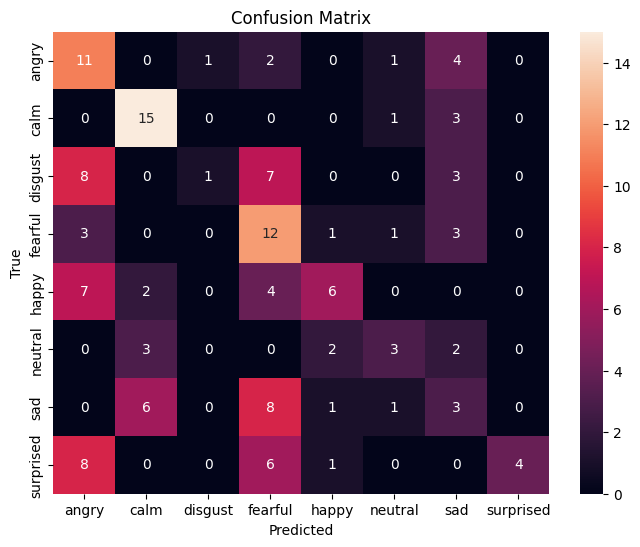

In [49]:
cm = confusion_matrix(y_test, y_pred_labels)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [50]:
def get_gender_from_path(path):
    actor_id = int(path.split("Actor_")[1].split("/")[0])
    return "male" if actor_id % 2 == 1 else "female"


In [51]:
male_idx = [i for i, p in enumerate(X_test_paths)
            if get_gender_from_path(p) == "male"]

female_idx = [i for i, p in enumerate(X_test_paths)
              if get_gender_from_path(p) == "female"]

male_f1 = f1_score(
    y_test[male_idx],
    y_pred_labels[male_idx],
    average='macro'
)

female_f1 = f1_score(
    y_test[female_idx],
    y_pred_labels[female_idx],
    average='macro'
)

print("Male Macro F1:", male_f1)
print("Female Macro F1:", female_f1)


Male Macro F1: 0.348087608432436
Female Macro F1: 0.3444964043309632


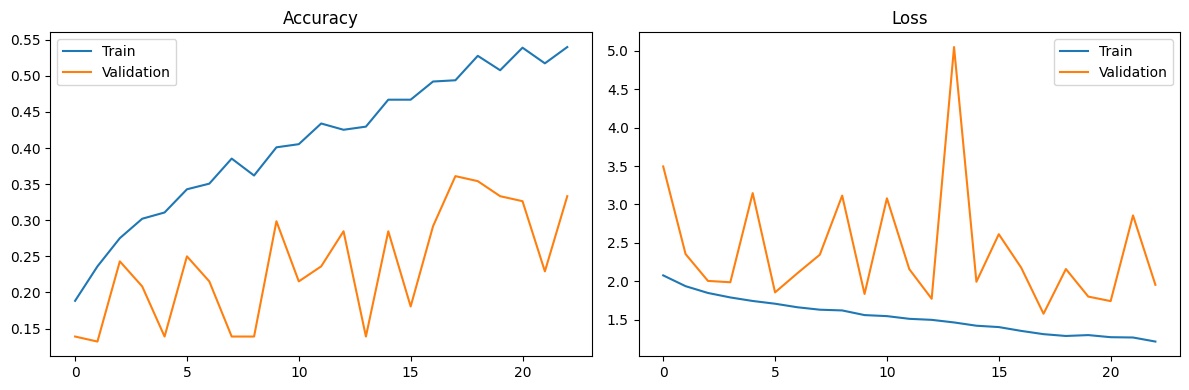

In [52]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [54]:
model.save("ser_cnn_model.keras")



In [56]:
import tensorflow as tf

model = tf.keras.models.load_model("ser_cnn_model.h5")
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 111,114 (434.04 KB)

 Trainable params: 110,664 (432.28 KB)

 Non-trainable params: 448 (1.75 KB)

 Optimizer params: 2 (12.00 B)

In [70]:
%%writefile predict.py
import sys
import os
import numpy as np
import librosa
import tensorflow as tf

EMOTIONS = [
    "Neutral",
    "Calm",
    "Happy",
    "Sad",
    "Angry",
    "Fearful",
    "Disgust",
    "Surprised"
]

MODEL_PATH = "ser_cnn_model.h5"


def preprocess_audio(file_path, sr=22050):
    y, sr = librosa.load(file_path, sr=sr)
    y, _ = librosa.effects.trim(y, top_db=20)

    max_len = 3 * sr
    if len(y) > max_len:
        y = y[:max_len]
    else:
        y = np.pad(y, (0, max_len - len(y)))

    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    log_mel = librosa.power_to_db(mel, ref=np.max)

    if log_mel.shape[1] < 128:
        log_mel = np.pad(log_mel, ((0, 0), (0, 128 - log_mel.shape[1])))
    else:
        log_mel = log_mel[:, :128]

    log_mel = (log_mel - log_mel.mean()) / log_mel.std()


    return log_mel[np.newaxis, ..., np.newaxis]


def main():
    args = [a for a in sys.argv[1:] if a.endswith(".wav")]

    if len(args) == 0:
        print("ERROR: No .wav file provided.")
        print("Usage: python predict.py <audio_file.wav>")
        sys.exit(1)

    audio_path = args[0]

    if not os.path.exists(audio_path):
        print(f"ERROR: File not found: {audio_path}")
        sys.exit(1)

    model = tf.keras.models.load_model(MODEL_PATH)

    features = preprocess_audio(audio_path)
    predictions = model.predict(features)[0]

    idx = np.argmax(predictions)
    print(f"Predicted Emotion: {EMOTIONS[idx]}")
    print(f"Confidence: {predictions[idx] * 100:.2f}%")


if __name__ == "__main__":
    main()


Overwriting predict.py


In [61]:
!ls

Actor_01  Actor_07  Actor_13  Actor_19	audio_speech_actors_01-24
Actor_02  Actor_08  Actor_14  Actor_20	ravdess-emotional-speech-audio.zip
Actor_03  Actor_09  Actor_15  Actor_21	sample_data
Actor_04  Actor_10  Actor_16  Actor_22	ser_cnn_model.h5
Actor_05  Actor_11  Actor_17  Actor_23	ser_cnn_model.keras
Actor_06  Actor_12  Actor_18  Actor_24


In [66]:
!python predict.py Actor_01/03-01-05-01-01-01-01.wav


2026-02-07 18:00:34.047218: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1770487234.112741   36544 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1770487234.133342   36544 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1770487234.200219   36544 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770487234.200290   36544 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770487234.200297   36544 computation_placer.cc:177] computation placer alr